In [1]:
import pandas as pd
import json
from pandas import json_normalize
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph
from rdflib.namespace import FOAF, RDF

## MODELO DE LOS DATOS
La ontología-conferencia es una nueva ontología autónoma para modelar el conocimiento sobre las conferencias. La ontología de conferencia adopta las mejores prácticas de diseño de ontologías (p. ej., patrones de diseño de ontologías, reutilización e interconexión de ontologías) y garantiza la interoperabilidad con la ontología SWC y todos los demás vocabularios pertinentes.

![title](capturas/model.png)

## DIMENSIONAMIENTO DE LOS DATOS RDF

### Obtención de la dimensión o cantidad de clases que existen

In [2]:
endPoint = "http://MSI:7200/repositories/ProyectoDatos"
#endPoint = "http://DESKTOP-3KNOEN3:7200/repositories/PROYECTO"

sparql = SPARQLWrapper(endPoint)

def getClassesDimention():
    query = """
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    SELECT DISTINCT ?class (count(?class) as ?count)
    WHERE{
     [ ] a ?class.
    
        FILTER(regex(str(?class), 'https://w3id.org/scholarlydata/ontology/conference-ontology.owl#', 'i')) 

    }GROUP BY ?class
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getClassesDimention()
df = json_normalize(results["results"]["bindings"]) #Res



In [3]:
df['class'] = df['class.value'].str.lstrip('https://w3id.org/scholarlydata/ontology/conference-ontology.owl#')
df = df[['class', 'count.value']]


<class 'numpy.int32'>


c:\users\roberto narvaez\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


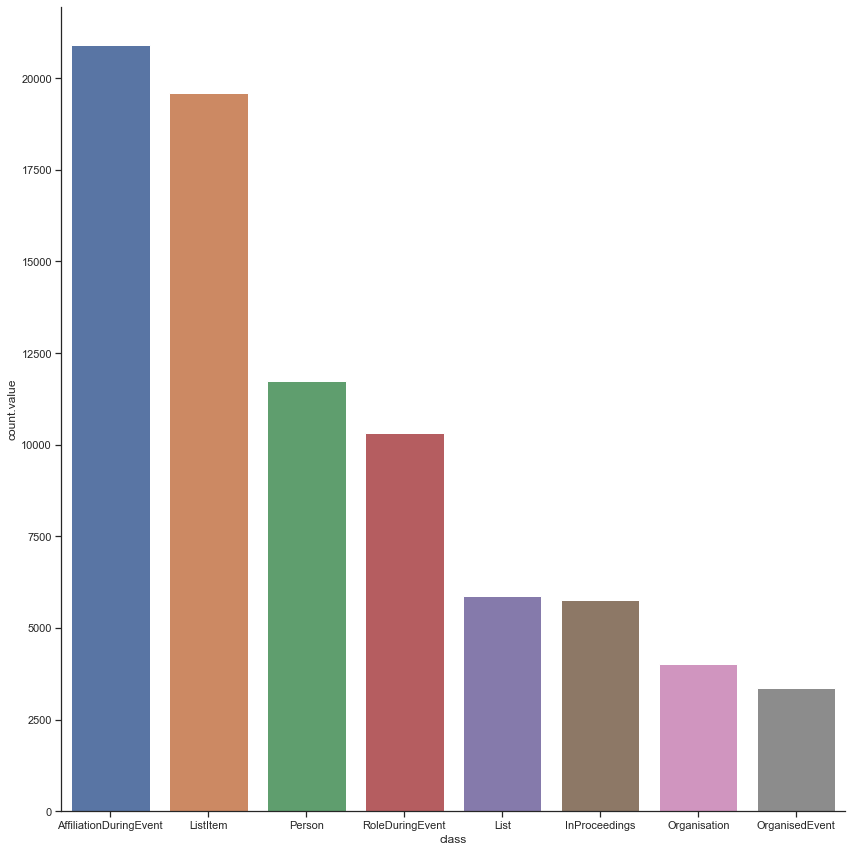

In [4]:
df['count.value'] = df['count.value'].astype(int)
print(type(df["count.value"][0]))
df = df.sort_values('count.value',ascending=False).head(8)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

sns.catplot(x="class", y="count.value", kind="bar", data=df, size=12)


### Cantidad de propiedades que existen en la Ontologia

In [54]:
def getPropertiesDimention():
    query = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>

    SELECT DISTINCT ?prop (count(*) AS ?count)
        WHERE {
            ?prop a rdf:Property.
            [] ?prop ?object.
        }group by ?prop
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getPropertiesDimention()
df2 = json_normalize(results["results"]["bindings"]) #Res


In [55]:
from urllib.parse import urlparse
for index, row in df2.iterrows():
    row['prop.value'] = urlparse(row['prop.value']).fragment
    row['count.value'] = int(row['count.value'])

df2 = df2[['prop.value', 'count.value']]
df2 = df2.sort_values('count.value',ascending=False).head(7)
df2

,prop.value,count.value
0,type,82383
8,label,35669
26,during,31314
5,sameAs,23394
24,isAffiliationOf,20903
25,withOrganisation,20903
23,hasAffiliation,20903


<AxesSubplot:ylabel='count.value'>

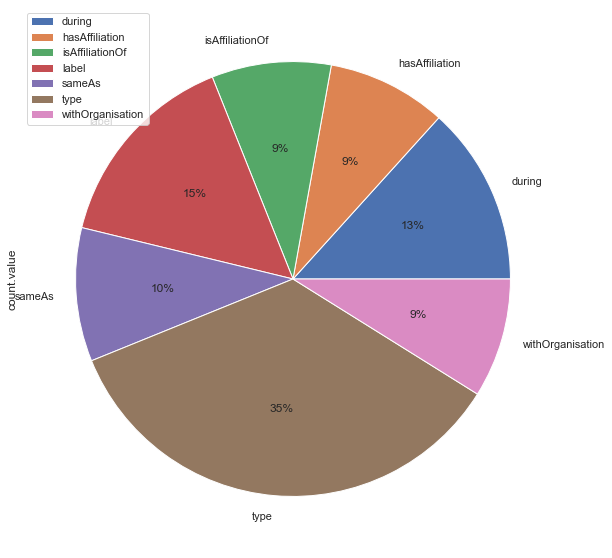

In [56]:
df2.groupby(['prop.value']).sum().plot(kind='pie', y='count.value', autopct='%1.0f%%', figsize=(10,10))

## ¿Que Papers conllevan más autores?

In [57]:
def getPapers():
    query = """
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    SELECT DISTINCT ?paper ?title ?person ?name ?doi
    WHERE{
      ?paper a conf:InProceedings;
        conf:hasAuthorList ?authorList;
        conf:title ?title .
      ?authorList conf:hasFirstItem ?item .
      ?item conf:hasContent ?person .
      ?person conf:name ?name
    }
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getPapers()
df3 = json_normalize(results["results"]["bindings"]) #Res
df3 = df3[['paper.value','title.value', 'name.value']]
df3

,paper.value,title.value,name.value
0,https://w3id.org/scholarlydata/inproceedings/c...,Identifying Information Needs by Modelling Col...,Khadija Elbedweihy
1,https://w3id.org/scholarlydata/inproceedings/c...,Incremental SPARQL Evaluation for Query Answer...,Florian Schmedding
2,https://w3id.org/scholarlydata/inproceedings/c...,LODWheel – JavaScript-based Visualization of R...,Magnus Stuhr
3,https://w3id.org/scholarlydata/inproceedings/c...,The Information Workbench as a Self-Service Pl...,Peter Haase
4,https://w3id.org/scholarlydata/inproceedings/c...,Towards Green Linked Data,Julia Hoxha
...,...,...,...
6170,https://w3id.org/scholarlydata/inproceedings/x...,Extraction of Onomatopoeia Used for Foods from...,Ayumi Kato
6171,https://w3id.org/scholarlydata/inproceedings/x...,Solution Mining for specific contextualised pr...,Christian Severin Sauer
6172,https://w3id.org/scholarlydata/inproceedings/x...,Extraction of procedural knowledge from the We...,Pol Schumacher
6173,https://w3id.org/scholarlydata/inproceedings/x...,"Collecting, reusing and executing private work...",Sebastian Görg


In [9]:
df3['name'] = df3['name.value'] 
p = df3.groupby('title.value').name.nunique().reset_index()
print(p.sort_values(by=['name'], ascending=False))

                                            title.value  name
4491  Summary Models for Routing Keywords to Linked ...     7
2354  IBSE: An OWL Interoperability Evaluation Infra...     6
4731     The Object with States Ontology Design Pattern     6
2236  Guidelines for Benchmarking the Performance of...     6
3384  Ontology-based Interpretation of Keywords for ...     5
...                                                 ...   ...
1909  Exploring Semantic Features for Producing Top-...     1
1908             Exploring Scholarly Data with Rexplore     1
1907                Exploring RDF/S KBs Using Summaries     1
1906         Exploring Linked Open Data with Tag Clouds     1
5495  ♠ Demo: An Open Source Tool for Partial Parsin...     1

[5496 rows x 2 columns]
Summary Models for Routing Keywords to Linked Data Sources


## Papers relacionados con SPARQL o RDF

In [58]:
def getPapers():
    query = """
    PREFIX person: <https://w3id.org/scholarlydata/person/>
    PREFIX conf: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    SELECT DISTINCT ?paper ?title ?abstract
    WHERE{
       VALUES ?tipoPaper{'SPARQL' 'RDF'}
      ?paper a conf:InProceedings;
        conf:hasAuthorList ?authorList;
        conf:title ?title;
        conf:abstract ?abstract. 
       filter contains(UCASE(?title), ?tipoPaper) 
    }
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getPapers()
df4 = json_normalize(results["results"]["bindings"]) #Res
df4 = df4[['paper.value', 'title.value','abstract.value']]
df4

,paper.value,title.value,abstract.value
0,https://w3id.org/scholarlydata/inproceedings/e...,Freshening Up While Staying Fast: Towards Hybr...,Linked Data querying over cached indexes of We...
1,https://w3id.org/scholarlydata/inproceedings/e...,Vocabulary Services Based on SPARQL Endpoints:...,Vocabularies are an integral part of Linked Da...
2,https://w3id.org/scholarlydata/inproceedings/e...,Flexible RDF generation from RDF and heterogen...,RDF aims at being the universal abstract data ...
3,https://w3id.org/scholarlydata/inproceedings/e...,Extraction and Visualization of TBox Informati...,The growing amount of data being published as ...
4,https://w3id.org/scholarlydata/inproceedings/e...,An Evolutionary Algorithm to Learn SPARQL Quer...,Efficient usage of the knowledge provided by t...
...,...,...,...
382,https://w3id.org/scholarlydata/inproceedings/w...,D2RQ/Update: Updating Relational Data via Virt...,D2RQ is a popular RDB-to-RDF mapping platform ...
383,https://w3id.org/scholarlydata/inproceedings/w...,On Directly Mapping Relational Databases to RD...,Mapping relational databases to RDF is a funda...
384,https://w3id.org/scholarlydata/inproceedings/w...,Getting More RDF Support from Relational Datab...,"We introduce the database fragment of RDF, whi..."
385,https://w3id.org/scholarlydata/inproceedings/w...,"Binary RDF for Scalable Publishing, Exchanging...",The Web of Data is producing increasingly larg...


## Cantidad de eventos que se dieron en determinadas localizaciones

In [13]:
def getEvents():
    query = """
    PREFIX cofunc: <https://w3id.org/scholarlydata/ontology/conference-ontology.owl#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    SELECT DISTINCT ?event ?nameEvent ?loc ?desc 
        WHERE {
            ?event a cofunc:OrganisedEvent;
            rdfs:label ?nameEvent;
            cofunc:description ?desc;
            cofunc:location ?loc;
            }
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    return sparql.query().convert()

results = getEvents()
df5 = json_normalize(results["results"]["bindings"]) #Res
df5['event'] = df5['event.value']

q = df5.groupby('loc.value').event.nunique().reset_index()
q1 = q.sort_values('event',ascending=False).head(5)
print(q1)

        loc.value  event
19  Mediteranea 2     20
4        Aurora 1     18
0     098 260.098     17
14        Emerald     16
18  Mediteranea 1     15


<AxesSubplot:ylabel='event'>

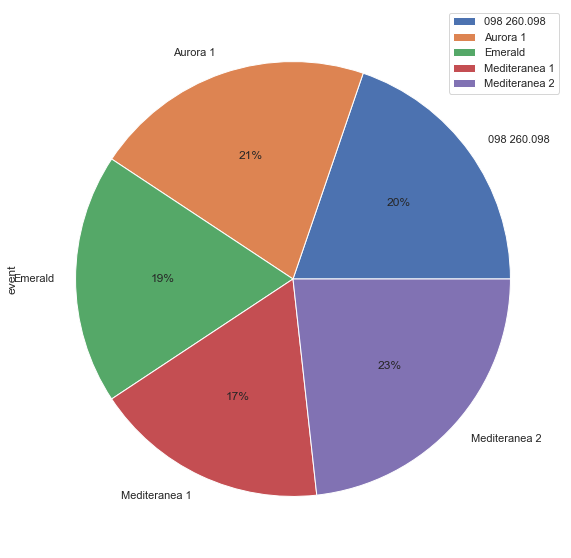

In [14]:
q1.groupby(['loc.value']).sum().plot(kind='pie', y='event', autopct='%1.0f%%', figsize=(10,10))

### Obtener anotaciones del Abstract mediante dbpedia Spotlight 

In [1]:
import spotlight 
from functools import partial

endpoint = 'https://api.dbpedia-spotlight.org/en/'


text = df4['abstract.value'][0]

def getAnnotations(text, confidence=0.4, support=20):
    
    annotations = spotlight.annotate(endpoint + 'annotate', text, confidence=confidence, support=support)
    listAnn = []
    for a in annotations:
        listAnn.append([a['URI'], a['support'], a['types'], a['surfaceForm'], a['similarityScore']])
    return listAnn

print(getAnnotations(text))

NameError: name 'df4' is not defined

In [21]:
listaPapersAnnotations = []
for index, row in df4.iterrows():
    #getAnnotations(row['abstract.value'])
    listaPapersAnnotations.append([row['paper.value'], getAnnotations(row['abstract.value'])])
    #print(row['abstract.value'])

In [22]:
print(listaPapersAnnotations[0])

['https://w3id.org/scholarlydata/inproceedings/ekaw2012/paper/research/71', [['http://dbpedia.org/resource/Linked_data', 256, '', 'Linked Data', 1.0], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Runtime_system', 446, '', 'runtime', 0.9999992261688969], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Linked_data', 256, '', 'Linked Data', 1.0], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Black_box', 323, '', 'black boxes', 0.9999999892345387], ['http://dbpedia.org/resource/Hybrid_electric_vehicle', 1356, '', 'hybrid', 0.8955368841098621], ['http://dbpedia.org/resource/Cache_coherence', 182, '', 'cached', 0.9998825725527143], ['http://dbpedia.org/resource/Linked_data', 2

In [23]:
print(str(df4['abstract.value'][0]),"->",str(df4['paper.value'][0]))

Linked Data querying over cached indexes of Web data often suffers from stale or missing results due to infrequent updates and partial coverage of available sources. Conversely, live decentralised approaches offer fresh results taken directly from the Web, but suffer from slow response times due to the expense of numerous remote lookups at runtime. We thus propose a hybrid query approach that improves upon both paradigms, offering fresher results from a broader range of sources than Linked Data caches while offering faster results than live querying. Our hybrid query engine takes a cached and live query engine as black boxes, where a hybrid query planner splits an input query and delegates the appropriate sub-queries to each interface. In this paper, we discuss the core query-planning issues and their main strengths and weaknesses. We also present coherence measures to quantify the coverage and freshness for cached indexes of Linked Data, and show how these measures can be used during 

### Creación de un nuevo Grafo con datos RDF 

Ectructura:

Paper -> dct:subject -> Annotations

In [24]:
from rdflib import Graph
from rdflib import Namespace
from rdflib import URIRef, BNode, Literal

# import prefixes of models that I will reuse:
from rdflib.namespace import FOAF, RDF

# Añadiendo namespace de Dublin Core Terms
dct = Namespace('http://purl.org/dc/terms/')
g = Graph()

In [25]:
schema = Namespace('http://schema.org/')
for a in listaPapersAnnotations:
    #print(a[1][0][4])#Score
    #print(a[1][0][0])#URI Annotation
    score = a[1][0][4]
    if (score >= 0.90):
        uriAnnotation = URIRef(a[1][0][0])
        uriPaper = URIRef(a[0])
        g.add((uriPaper, schema:mentions, uriAnnotation))
        #print(a[0],'->','dct:subject', a[1][0][0])

### Nuevas Tripletas de papers con dct:subject

In [26]:
g.print()

@prefix ns1: <http://purl.org/dc/terms/> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-pd-260> ns1:subject <http://dbpedia.org/resource/Resource_Description_Framework> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-pd-267> ns1:subject <http://dbpedia.org/resource/Linked_data> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-phdsym-245> ns1:subject <http://dbpedia.org/resource/Resource_Description_Framework> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-129> ns1:subject <http://dbpedia.org/resource/DBpedia> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-156> ns1:subject <http://dbpedia.org/resource/Linked_data> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-157> ns1:subject <http://dbpedia.org/resource/Linked_data> .

<https://w3id.org/scholarlydata/inproceedings/ekaw-2016-research%2Binuse-195> ns1:subject <http://dbpedia.org/resource/Resource_Description_Framework>

In [27]:
g.serialize(destination="papersWithAnnotations.ttl")

<Graph identifier=N8b3d893e4a0546659d6dd52f741f8594 (<class 'rdflib.graph.Graph'>)>

## Enriquecimiento de datos consumiendo Endpoint de Dbpedia

annotation -> rdfs:label -> label@en <br>
annotation -> dct:subject -> uriSubject

In [34]:
import json
from pandas import json_normalize
from SPARQLWrapper import SPARQLWrapper, JSON


dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
dbc = Namespace('http://dbpedia.org/resource/Category:')

def get_Query(query):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setReturnFormat(JSON)

    sparql.setQuery(query)  # the previous query as a literal string

    return sparql.query().convert()

In [ ]:
g2 = Graph()

rdfs = Namespace('http://www.w3.org/2000/01/rdf-schema#')

endPointDB = "http://dbpedia.org/sparql"
sparql = SPARQLWrapper(endPoint)
try:
    
    for a in listaPapersAnnotations:
        #print(a[1][0][4])#Score
        #print(a[1][0][0])#URI Annotation
        score = a[1][0][4]
        if (score >= 0.90):
            uriAnnotation = str(a[1][0][0]).replace('http://dbpedia.org/resource/', 'dbr:')
            query = """select distinct ?label ?cat where <{} rdfs:label ?label .{} dct:subject ?cat. FILTER (lang(?label) = 'en')>""".format(uriAnnotation,uriAnnotation).replace('<','{').replace('>','}')
            dataDbpedia = get_Query(query)
            df8 = json_normalize(dataDbpedia["results"]["bindings"]) #Res
            
            uriAnn = URIRef(a[1][0][0])
            
            for index, row in df8.iterrows():
                label = Literal(str(row['label.value']))
                category = URIRef(row['cat.value'])
                g2.add((uriAnn, dct.subject, category))
                g2.add((uriAnn, rdfs.label, label))
                
                #print(a[1][0][0], '->', row['cat.value'])
                #print(row['cat.value'])
                
            
            #g2.add((uriAnn, rdfs.label, label))
            #g2.add((uriAnn, dct.subject, label))
            
            #print(df['cat.value'])
            #print(query)


            #g.add((uriPaper, dct.subject, uriAnnotation))
            #print(a[0],'->','dct:subject', a[1][0][0])
except:
    print('Query no valida: ',query)
    pass

In [ ]:
g2.print()

In [ ]:
g2.serialize(destination="annotationsLabelsCategories.ttl")